In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Figure 3

In [2]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]

results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_51to60.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_11to20.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_1to10.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_71to80.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_61to70.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_81to90.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_31to40.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_91to100.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_21to30.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_41to50.csv


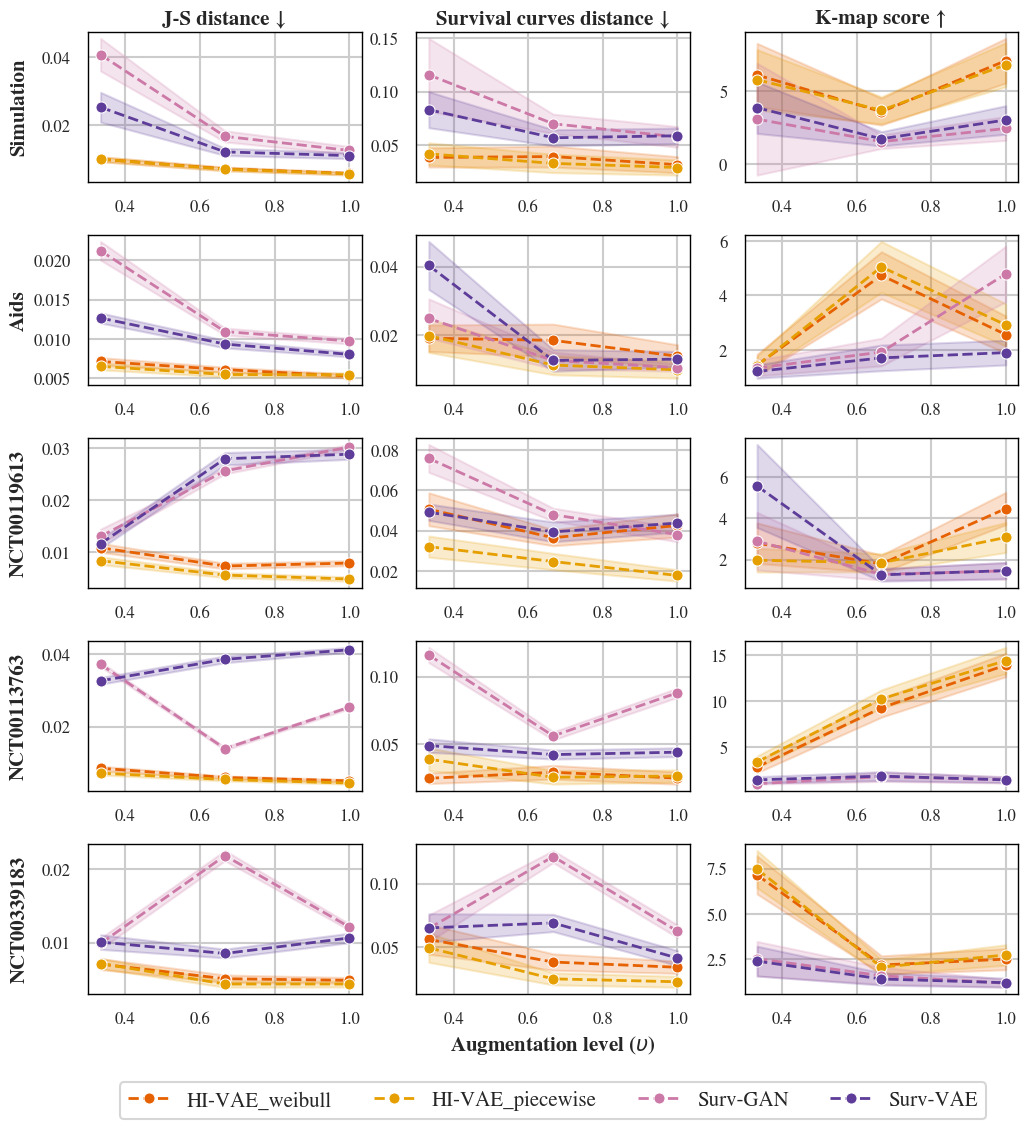

In [4]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path +  '/dataset/Simulations_aug_indep_traincontrol/'  # change to your folder path
file_names = os.listdir(folder_path)
results_control = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        print(name)
        results_control.append(pd.read_csv(folder_path + name,index_col=0))
results_control = pd.concat(results_control)
results_control = results_control.sort_values(by='XP_num')

treat_effects_control = np.unique(results_control.H0_coef.values)
aug_percs = np.unique(results_control.aug_perc.values)
for col in results_control.columns:
    results_control[col] = np.float64(results_control[col].values)


current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
metrics=[['J-S distance', "min"], ['Survival curves distance', "min"], ['K-map score', "max"]]
aug_percs = np.unique(results_control.aug_perc.values)
#### SYNTHCITY METRICS
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs_ = plt.subplots(5, num_metrics, figsize=(4 * len(aug_percs), 2.5 * 5))
plt.subplots_adjust(hspace=.35, wspace=0.2) 
palette = {'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#E66101",
           'HI-VAE_weibull_prior': "#ff9896", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"}

for j, ax in enumerate(axs_[0]):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    metric_df_ext = metric_df.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', markersize=8, marker = "o")
    ax.set_xlabel('')

    if j == 0:
        ax.set_ylabel("Simulation", fontsize=15, fontweight="semibold")
    else:
        ax.set_ylabel('')
    # if l == 0:
    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()


dataset_names = ["Aids", "SAS_1", "SAS_2", "SAS_3"]
list_n_samples_control = [(1/3), (2/3), 1.0]
for l, axs in enumerate(axs_[1:]):
    res_dir = parent_path +  "/dataset/" + dataset_names[l]
    results_ext = []
    for i in range(len(list_n_samples_control)):
        df_tmp = pd.read_csv(res_dir + '/metric_results/traincontrol_aug_Ncontrol{}%3_general_scores_df.csv'.format((i+1)))
        df_tmp["Augmentation percentage"] = (i+1)/3
        results_ext.append(df_tmp)
    results_ext = pd.concat(results_ext)
    results_ext = results_ext[results_ext.generator.isin(generators_sel)]
    results_ext_ = results_ext.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    results_ext_ = results_ext_[results_ext_.generator.isin(generators_sel)]
    for j, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[j]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

        sns.lineplot(data=results_ext, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                    linewidth = 2, palette = palette, errorbar = ("sd", .5),
                    linestyle='--', marker = "o", markersize=8)
        if (l == len(dataset_names) - 1) & (j == 1):
            ax.set_xlabel('Augmentation level ($\\upsilon$)', fontsize=15, fontweight="semibold")
        else:
            ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        if j == 0:
            if dataset_names[l] == "SAS_1":
                ax.set_ylabel("NCT00119613", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_2":
                ax.set_ylabel("NCT00113763", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_3":
                ax.set_ylabel("NCT00339183", fontsize=15, fontweight="semibold")
            else:
                ax.set_ylabel(dataset_names[l], fontsize=15, fontweight="semibold")
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend().remove()
fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.7, -.9), fontsize=15)
plt.savefig("../figures/datasets_perf_traincontrol", bbox_inches="tight")
plt.show()

### Figure 4

In [5]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path +  '/dataset/Simulations_aug_indep_traincontrol/'  # change to your folder path
file_names = os.listdir(folder_path)
results_control = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        print(name)
        results_control.append(pd.read_csv(folder_path + name,index_col=0))
results_control = pd.concat(results_control)
results_control = results_control.sort_values(by='XP_num')

treat_effects_control = np.unique(results_control.H0_coef.values)
aug_percs = np.unique(results_control.aug_perc.values)
for col in results_control.columns:
    results_control[col] = np.float64(results_control[col].values)

results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_51to60.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_11to20.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_1to10.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_71to80.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_61to70.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_81to90.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_31to40.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_91to100.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_21to30.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_41to50.csv


In [6]:
import matplotlib.ticker as ticker
import sys
from pathlib import Path
module_path = Path.cwd().parent / 'utils'
sys.path.append(str(module_path))
from simulations import *

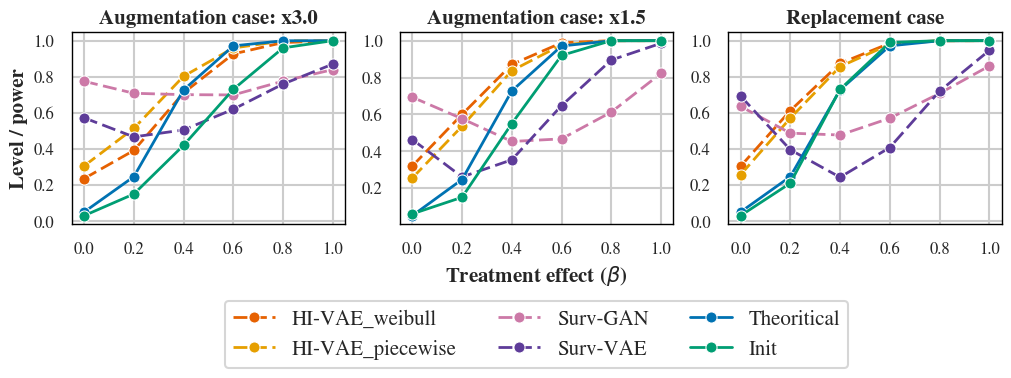

In [7]:
fig, axs = plt.subplots(1, len(aug_percs), figsize=(4 * len(aug_percs), 2.5))
plt.subplots_adjust(hspace=.35, wspace=0.2)  
palette = {"Theoritical": "#0072B2", 
           "Init": "#009E73",
           'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#E66101",
           'HI-VAE_weibull_prior': "#ff9896", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"}

custom_dashes = {"Theoritical": "", 
           "Init": "",
           'HI-VAE_piecewise' : (5,2),  
        #    'HI-VAE_piecewise_prior': (5,2), 
           'HI-VAE_weibull': (5,2),
        #    'HI-VAE_weibull_prior': (5,2), 
           'Surv-VAE': (5,2), 
           'Surv-GAN': (5,2)}
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
    power_theo = []
    # for j in range(len(H0_coef_univ_theo)):
    #     power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    # df = pd.concat([df, pd.DataFrame(np.array([["Theoritical"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
    #                                 columns=["Learner", "Treatment effect", "Power"])])
    # # axs[i].plot(treat_effects_control, np.array(power_theo), label = "Theoritical", marker="o")

    # results_ext_control["reject_H0_init"] = results_ext_control['log_pvalue_init'] > -np.log(0.05)
    # power_init = results_ext_control.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    # # axs[i].plot(treat_effects_control, power_init, '-', label = "Init", marker="o", markersize=8)
    # df = pd.concat([df, pd.DataFrame(np.array([["Init"] * len(power_init), treat_effects_control, np.array(power_init)]).T,
    #                                 columns=["Learner", "Treatment effect", "Power"])])

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
    for generator_name in generators_sel:
        results_ext_control["reject_H0_gen_" + generator_name] = results_ext_control['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext_control.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])
        # axs[i].plot(treat_effects_control, power_gen, '--', marker='o', label = generator_name,)

    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    # axs[i].plot(treat_effects_control, np.array(power_theo), label = "Theoritical", marker="o")

    results_ext_control["reject_H0_init"] = results_ext_control['log_pvalue_init'] > -np.log(0.05)
    power_init = results_ext_control.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    # axs[i].plot(treat_effects_control, power_init, '-', label = "Init", marker="o", markersize=8)
    df = pd.concat([df, pd.DataFrame(np.array([["Init"] * len(power_init), treat_effects_control, np.array(power_init)]).T,
                                    columns=["Learner", "Treatment effect", "Power"])])

    # axs[i].set_ylabel("Level / power")
    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    # print(min(df["Power"].values))
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[i].set_ylabel("")
    axs[0].set_ylabel("Level / power", fontweight="semibold", fontsize=15)
    axs[i].set_xlabel("")
    axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    if i < len(aug_percs)-1:
        axs[i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    # plt.legend()    
    axs[i].legend().remove()
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
# plt.xlabel("Treatment effect")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.8), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value", bbox_inches="tight")
plt.show()

### Figure 5

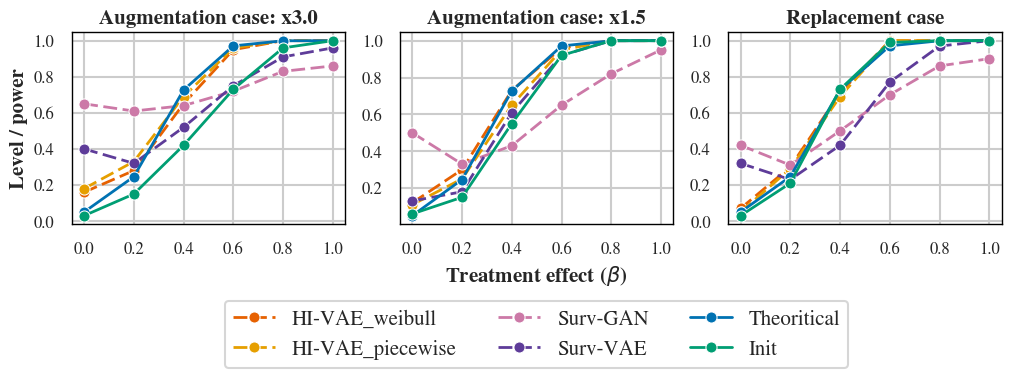

In [8]:
fig, axs = plt.subplots(1, len(aug_percs), figsize=(4 * len(aug_percs), 2.5))
plt.subplots_adjust(hspace=.35, wspace=0.2)  
palette = {"Theoritical": "#0072B2", 
           "Init": "#009E73",
           'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#E66101",
           'HI-VAE_weibull_prior': "#ff9896", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"}
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_control.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_control.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_control.groupby("H0_coef").mean()["D_treated"].to_numpy()
    power_theo = []
    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
    XP_num = np.unique(results_ext_control["XP_num"].values)
    for generator_name in generators_sel:
        results_MC_best_list = []
        for m in XP_num:
            results_MC = results_ext_control[results_ext_control["XP_num"] == m]
            best_metric = np.min(results_MC["log_pvalue_control_" + generator_name].values)
            results_MC_best = results_MC[results_MC["log_pvalue_control_" + generator_name] == best_metric].copy(deep=True)
            results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
            results_MC_best_list.append(results_MC_best)
        power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        # axs[i].plot(treat_effects_control, power_gen, '--', marker='o', label = generator_name,)
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])

    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])

    results_ext_control["reject_H0_init"] = results_ext_control['log_pvalue_init'] > -np.log(0.05)
    power_init = results_ext_control.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    # axs[i].plot(treat_effects_control, power_init, '-', label = "Init")
    df = pd.concat([df, pd.DataFrame(np.array([["Init"] * len(power_init), treat_effects_control, np.array(power_init)]).T,
                                    columns=["Learner", "Treatment effect", "Power"])])

    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    # print(min(df["Power"].values))
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[i].set_ylabel("")
    axs[0].set_ylabel("Level / power", fontweight="semibold", fontsize=15)
    axs[i].set_xlabel("")
    axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    if i < len(aug_percs)-1:
        axs[i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    # plt.legend()    
    axs[i].legend().remove()
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
# plt.xlabel("Treatment effect")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.8), fontsize=15)
plt.savefig("../figures/simu_datasets_traincontrol_p_value_best_gen", bbox_inches="tight")
plt.show()

### Figure 6

In [9]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
folder_path = parent_path + '/dataset/Simulations_aug_indep_trainfull/'  # change to your folder path
file_names = os.listdir(folder_path)
results_trainfull_1 = []
results_trainfull_2 = []
results_trainfull_3 = []
results_logrank = []
# Display the file names
for name in file_names:
    if 'results_survival_km_distance' in name:
        print(name)
        results_trainfull_1.append(pd.read_csv(folder_path + name,index_col=0))
    elif 'results_2_survival_km_distance' in name:
        print(name)
        results_trainfull_2.append(pd.read_csv(folder_path + name,index_col=0))
    elif 'results_3_survival_km_distance' in name:
        print(name)
        results_trainfull_3.append(pd.read_csv(folder_path + name,index_col=0))
results_trainfull_1 = pd.concat(results_trainfull_1)
results_trainfull_1 = results_trainfull_1.sort_values(by='XP_num')
results_trainfull_2 = pd.concat(results_trainfull_2)
results_trainfull_2 = results_trainfull_2.sort_values(by='XP_num')
results_trainfull_3 = pd.concat(results_trainfull_3)
results_trainfull_3 = results_trainfull_3.sort_values(by='XP_num')

treat_effects_trainfull_1 = np.unique(results_trainfull_1.H0_coef.values)
treat_effects_trainfull_2 = np.unique(results_trainfull_2.H0_coef.values)
treat_effects_trainfull_3 = np.unique(results_trainfull_3.H0_coef.values)
aug_percs = np.unique(results_trainfull_1.aug_perc.values)
for col in results_trainfull_1.columns:
    results_trainfull_1[col] = np.float64(results_trainfull_1[col].values)
print(f"treat_effects_trainfull_1: {treat_effects_trainfull_1}")
print(f"treat_effects_trainfull_2: {treat_effects_trainfull_2}")
print(f"treat_effects_trainfull_3: {treat_effects_trainfull_3}")
print(f"aug_percs: {aug_percs}")

results_trainfull_2["XP_num"] = results_trainfull_2.XP_num + results_trainfull_1.XP_num.max() + 1
results_trainfull_3["XP_num"] = results_trainfull_3.XP_num + results_trainfull_2.XP_num.max() + 1
results_trainfull = pd.concat([results_trainfull_1, results_trainfull_2, results_trainfull_3])
results_trainfull = results_trainfull.sort_values(by='H0_coef')
treat_effects_trainfull = np.unique(results_trainfull.H0_coef.values)

treat_effects_control = np.unique(results_trainfull.H0_coef.values)
aug_percs = np.unique(results_trainfull.aug_perc.values)
for col in results_trainfull.columns:
    results_trainfull[col] = np.float64(results_trainfull[col].values)

results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_12to22.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_45to55.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_67to77.csv
results_2_survival_km_distance_n_samples_600_n_features_bytype_6_MC_56to66.csv
results_2_survival_km_distance_n_samples_600_n_features_bytype_6_MC_23to33.csv
results_2_survival_km_distance_n_samples_600_n_features_bytype_6_MC_78to88.csv
results_3_survival_km_distance_n_samples_600_n_features_bytype_6_MC_56to66.csv
results_3_survival_km_distance_n_samples_600_n_features_bytype_6_MC_78to88.csv
results_3_survival_km_distance_n_samples_600_n_features_bytype_6_MC_23to33.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_34to44.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_1to11.csv
results_survival_km_distance_n_samples_600_n_features_bytype_6_MC_89to99.csv
results_2_survival_km_distance_n_samples_600_n_features_bytype_6_

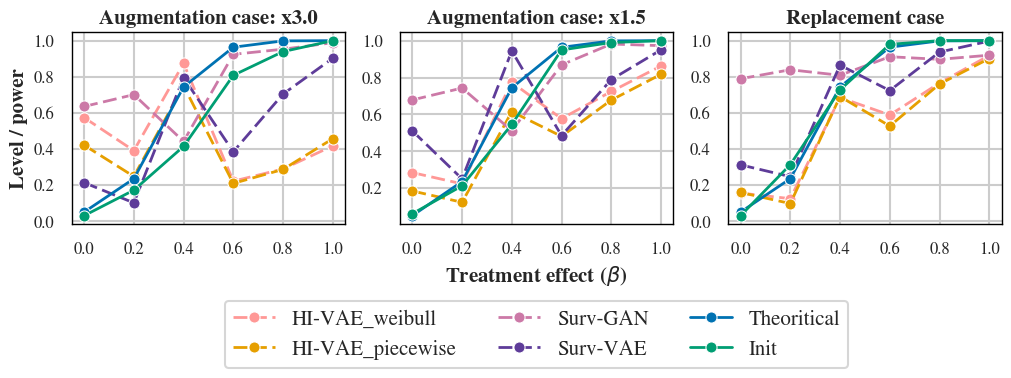

In [10]:
fig, axs = plt.subplots(1, len(aug_percs), figsize=(4 * len(aug_percs), 2.5))
plt.subplots_adjust(hspace=.35, wspace=0.2)  
palette = {"Theoritical": "#0072B2", 
           "Init": "#009E73",
           'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#ff9896",
           'HI-VAE_weibull_prior': "#E66101", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"} 
for i, aug_perc in enumerate(aug_percs):
    df = pd.DataFrame(columns=["Learner", "Treatment effect", "Power"])
    for spine in axs[i].spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    results_ext_full = results_trainfull[results_trainfull.aug_perc == aug_perc].copy(deep=True)
    H0_coef_univ_theo = results_ext_full.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
    D_control_theo = results_ext_full.groupby("H0_coef").mean()["D_control"].to_numpy()
    D_treated_theo = results_ext_full.groupby("H0_coef").mean()["D_treated"].to_numpy()
    power_theo = []

    custom_palette = ['deepskyblue', 'darkblue', 'orange', 'red']
    for generator_name in generators_sel:
        results_ext_full["reject_H0_gen_" + generator_name] = results_ext_full['log_pvalue_' + generator_name] > -np.log(0.05)
        power_gen = results_ext_full.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
        df = pd.concat([df, pd.DataFrame(np.array([[generator_name] * len(power_gen), treat_effects_control, np.array(power_gen)]).T,
                                        columns=["Learner", "Treatment effect", "Power"])])
        # axs[i].plot(treat_effects_control, power_gen, '--', marker='o', label = generator_name,)

    for j in range(len(H0_coef_univ_theo)):
        power_theo.append(cpower(D_control_theo[j], D_treated_theo[j], H0_coef_univ_theo[j], 0.05))
    df = pd.concat([df, pd.DataFrame(np.array([["Theoritical"] * len(power_theo), treat_effects_control, np.array(power_theo)]).T, 
                                    columns=["Learner", "Treatment effect", "Power"])])
    # axs[i].plot(treat_effects_control, np.array(power_theo), label = "Theoritical", marker="o")

    results_ext_full["reject_H0_init"] = results_ext_full['log_pvalue_init'] > -np.log(0.05)
    power_init = results_ext_full.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
    # axs[i].plot(treat_effects_control, power_init, '-', label = "Init", marker="o", markersize=8)
    df = pd.concat([df, pd.DataFrame(np.array([["Init"] * len(power_init), treat_effects_control, np.array(power_init)]).T,
                                    columns=["Learner", "Treatment effect", "Power"])])

    # axs[i].set_ylabel("Level / power")
    df["Treatment effect"] = pd.to_numeric(df["Treatment effect"], errors="coerce")
    df["Power"] = pd.to_numeric(df["Power"], errors="coerce")
    # print(min(df["Power"].values))
    sns.lineplot(data=df, x="Treatment effect", y="Power", hue="Learner", ax=axs[i], style="Learner",
                        linewidth = 2, palette = palette, marker="o", markersize=8, dashes=custom_dashes)
    axs[i].set_ylabel("")
    axs[0].set_ylabel("Level / power", fontweight="semibold", fontsize=15)
    axs[i].set_xlabel("")
    axs[1].set_xlabel("Treatment effect ($\\beta$)", fontweight="semibold", fontsize=15)
    if i < len(aug_percs)-1:
        axs[i].set_title("Augmentation case: x{}".format(1/(aug_perc)), fontweight="semibold", fontsize=15)
    else: 
        axs[i].set_title("Replacement case", fontweight="semibold", fontsize=15)
    # plt.legend()    
    axs[i].legend().remove()
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 1 unit
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # every 2 units
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
# plt.xlabel("Treatment effect")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(-.7, -.8), fontsize=15)
plt.savefig("../figures/simu_datasets_trainfull_p_value", bbox_inches="tight")
plt.show()

### Figure 7

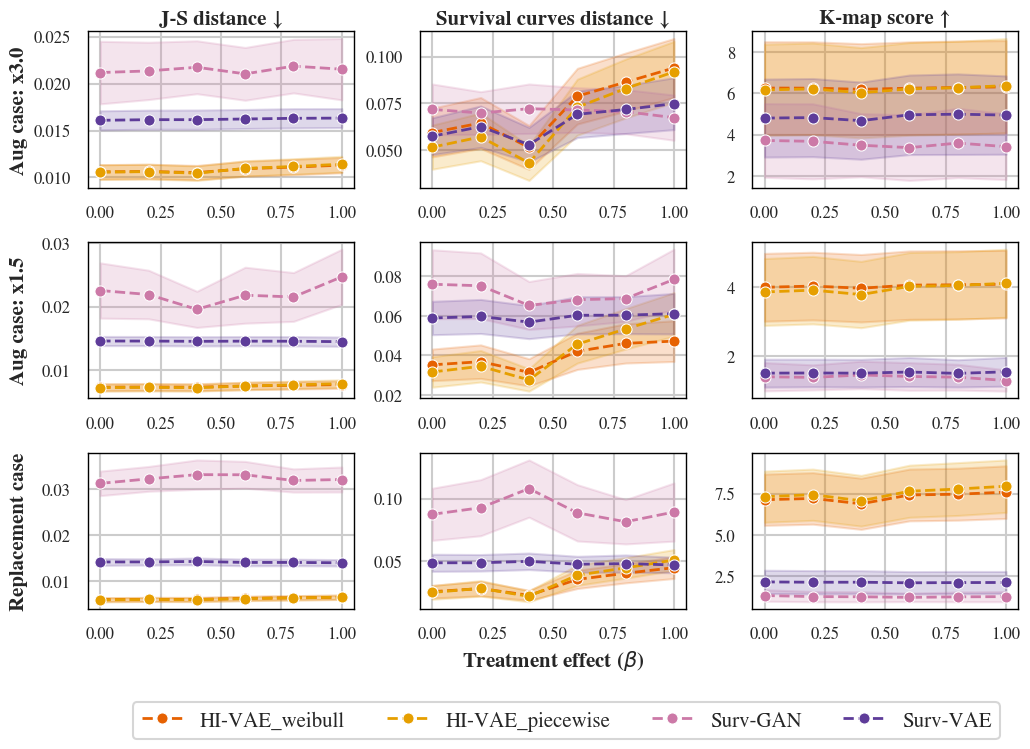

In [11]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
metrics=[['J-S distance', "min"], ['Survival curves distance', "min"], ['K-map score', "max"]]
aug_percs = np.unique(results_trainfull.aug_perc.values)
palette = {'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#E66101",
           'HI-VAE_weibull_prior': "#ff9896", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"}
#### SYNTHCITY METRICS
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs_ = plt.subplots(len(aug_percs), num_metrics, figsize=(4 * len(metrics), 2.5 * len(aug_percs)))
plt.subplots_adjust(hspace=.35, wspace=0.25)  

for l ,axs in enumerate(axs_):
    for j, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[j]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

        metric_df = pd.DataFrame()

        results_ext_trainfull = results_trainfull[results_trainfull.aug_perc == aug_percs[l]].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_trainfull.shape[0],
                                                            results_ext_trainfull.H0_coef,       
                                                            results_ext_trainfull[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', "Treatment effect", metric_name])])
        metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
        metric_df["Treatment effect"] = pd.to_numeric(metric_df["Treatment effect"], errors="coerce")
        metric_df_ext = metric_df.groupby(["Treatment effect", "generator"]).mean().reset_index()
        sns.lineplot(data=metric_df, x="Treatment effect", y=metric_name, hue="generator", ax=ax,
                    linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', marker = "o", markersize=8)

        if (l == len(aug_percs) - 1) & (j == 1):
            ax.set_xlabel('Treatment effect ($\\beta$)', fontsize=15, fontweight="semibold")
        else:
            ax.set_xlabel('')
        ax.set_ylabel('')
        if l == 0:
            if opt == "max":
                ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
            else:
                ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")
        # else:
        #     ax.set_title('')
        if j == 0:
            if aug_percs[l] == 1/3:
                ax.set_ylabel("Aug case: x3.0", fontsize=15, fontweight="semibold")
            elif aug_percs[l] == 2/3:
                ax.set_ylabel("Aug case: x1.5", fontsize=15, fontweight="semibold")
            else:
                ax.set_ylabel("Replacement case", fontsize=15, fontweight="semibold")

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend().remove()

fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.7, -.9), fontsize=15)
plt.savefig("../figures/simu_datasets_trainfull_perf", bbox_inches="tight")
plt.show()

### Figure 9 (Appendix)

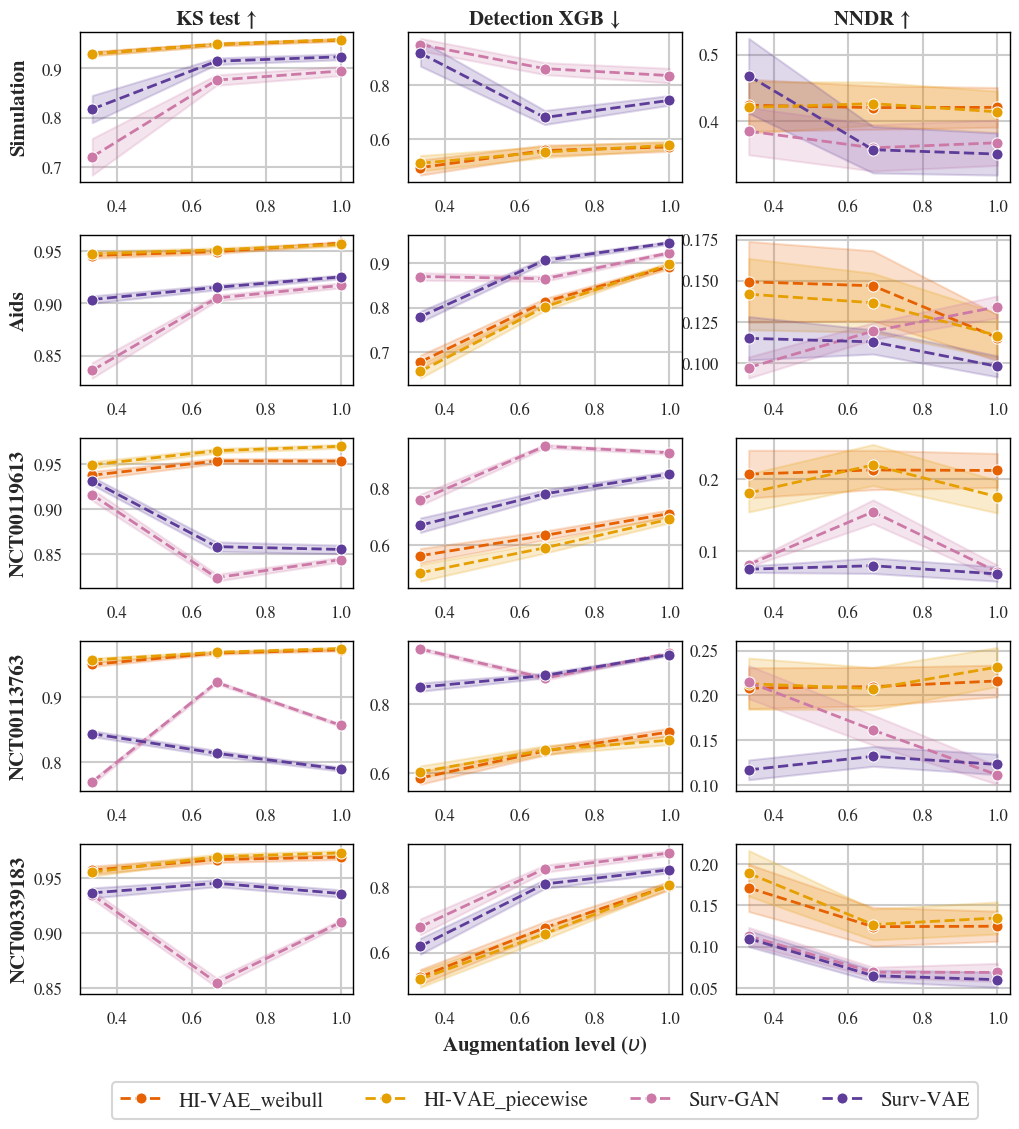

In [12]:
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
metrics=[['KS test', "max"], ['Detection XGB', "min"], ['NNDR', "max"]]
aug_percs = np.unique(results_control.aug_perc.values)
#### SYNTHCITY METRICS
num_metrics = len(metrics)
n_learners = len(generators_sel)
fig, axs_ = plt.subplots(5, num_metrics, figsize=(4 * len(aug_percs), 2.5 * 5))
plt.subplots_adjust(hspace=.35, wspace=0.2) 
palette = {'HI-VAE_piecewise' : "#E69F00",  
           'HI-VAE_piecewise_prior': "#F0E442", 
           'HI-VAE_weibull': "#E66101",
           'HI-VAE_weibull_prior': "#ff9896", 
           'Surv-VAE': "#5E3C99", 
           'Surv-GAN': "#CC79A7"}

for j, ax in enumerate(axs_[0]):
    # Format axis spines
    metric_name, opt = metrics[j]
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor('black')

    metric_df = pd.DataFrame()
        
    for aug_perc in aug_percs:
        results_ext_control = results_control[results_control.aug_perc == aug_perc].copy(deep=True)
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_ext_control.shape[0],
                                                            [aug_perc] * results_ext_control.shape[0],       
                                                            results_ext_control[metric_name + "_" + generator_name].values.astype(float)]).T,
                                                            columns=['generator', "Augmentation percentage", metric_name])])
    
    metric_df[metric_name] = pd.to_numeric(metric_df[metric_name], errors="coerce")
    metric_df["Augmentation percentage"] = pd.to_numeric(metric_df["Augmentation percentage"], errors="coerce")
    metric_df_ext = metric_df.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    sns.lineplot(data=metric_df, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                linewidth = 2, palette = palette, errorbar = ("sd", .5), linestyle='--', markersize=8, marker = "o")

    # if j == 1:
    #     ax.set_xlabel('Augmentation level ($\\upsilon$)', fontsize=15, fontweight="semibold")
    # else:
    #     ax.set_xlabel('')
    ax.set_xlabel('')

    if j == 0:
        ax.set_ylabel("Simulation", fontsize=15, fontweight="semibold")
    else:
        ax.set_ylabel('')
    # if l == 0:
    if opt == "max":
        ax.set_title(metric_name + ' ' +'\u2191', fontsize=15, fontweight="semibold")
    else:
        ax.set_title(metric_name + ' ' + '\u2193', fontsize=15, fontweight="semibold")

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend().remove()


dataset_names = ["Aids", "SAS_1", "SAS_2", "SAS_3"]
list_n_samples_control = [(1/3), (2/3), 1.0]
for l, axs in enumerate(axs_[1:]):
    res_dir = parent_path +  "/dataset/" + dataset_names[l]
    results_ext = []
    for i in range(len(list_n_samples_control)):
        df_tmp = pd.read_csv(res_dir + '/metric_results/traincontrol_aug_Ncontrol{}%3_general_scores_df.csv'.format((i+1)))
        df_tmp["Augmentation percentage"] = (i+1)/3
        results_ext.append(df_tmp)
    results_ext = pd.concat(results_ext)
    results_ext = results_ext[results_ext.generator.isin(generators_sel)]
    results_ext_ = results_ext.groupby(["Augmentation percentage", "generator"]).mean().reset_index()
    results_ext_ = results_ext_[results_ext_.generator.isin(generators_sel)]
    for j, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[j]
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_edgecolor('black')

        sns.lineplot(data=results_ext, x="Augmentation percentage", y=metric_name, hue="generator", ax=ax,
                    linewidth = 2, palette = palette, errorbar = ("sd", .5),
                    linestyle='--', marker = "o", markersize=8)
        if (l == len(dataset_names) - 1) & (j == 1):
            ax.set_xlabel('Augmentation level ($\\upsilon$)', fontsize=15, fontweight="semibold")
        else:
            ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title('')
        if j == 0:
            if dataset_names[l] == "SAS_1":
                ax.set_ylabel("NCT00119613", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_2":
                ax.set_ylabel("NCT00113763", fontsize=15, fontweight="semibold")
            elif dataset_names[l] == "SAS_3":
                ax.set_ylabel("NCT00339183", fontsize=15, fontweight="semibold")
            else:
                ax.set_ylabel(dataset_names[l], fontsize=15, fontweight="semibold")
        else:
            ax.set_ylabel('')

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend().remove()
fig.align_labels()
plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(-.7, -.9), fontsize=15)
plt.savefig("../figures/datasets_perf_traincontrol_sup", bbox_inches="tight")
plt.show()